Имеем данные о кредитных историях клиентов одного из банков. Проведем некоторый статистический анализ этих данных

Описание признаков:  
- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import zconfint
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests 

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('_5e732cdeb15894a04f77e5fae011e572_credit_card_default_analysis.csv')

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 1

Посмотрим на медианные значения кридитного лимита в групах, где клиенты банка вернули кредит (default = 0) и не вернули кредит (default = 1). 
- проверим гипотезу о том, что медианные значения равны в этих группах.
- проверим гипотезу о равенстве распределений в двуъ выборках

In [5]:
limit_no_default = df.loc[df['default'] == 0, ['LIMIT_BAL']]
limit_default = df.loc[df['default'] == 1, ['LIMIT_BAL']]

Посмотрим на распределения значений кредитного лимита

Text(0.5,1,'Default')

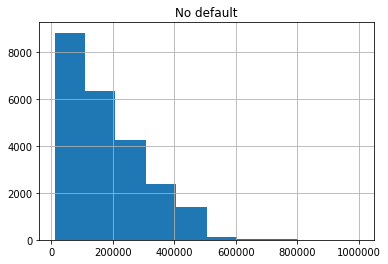

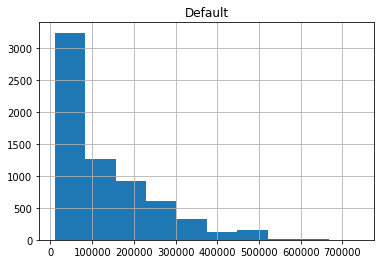

In [6]:
plt.figure(figsize = (10,8))
limit_no_default.hist()
plt.title('No default')
limit_default.hist()
plt.title('Default')

Для проверки гипотезы о равенстве медиан будем исользовать интервальную оценку на основе бутстрэпа

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (len(data), n_samples))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)
no_default_median = np.median(get_bootstrap_samples(limit_no_default.values, 3000), axis = 0)
default_median = np.median(get_bootstrap_samples(limit_default.values, 3000), axis = 0)
stat_intervals(no_default_median - default_median, 0.05)

array([ 60000.,  70000.])

Как видим, не возвращают зачастую меньшие кредиты, при чем мы получили практически значимый результат: медианный размер невозвращенных кредитов на 60000 - 70000 меньше, чем медианный размер возвращенных кредитов.

Проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни
- Н0: выборки имеют одно и то же распределение
- Н1: выборки имеют различные распределения

<b>Насколько я понял, для этого критерия не надо проверять никаких условий и можно просто применять его в лоб. Если это не так, напишите в комментарии, и скажите, в каких случаях он не применяется

In [10]:
stats.mannwhitneyu(limit_no_default, limit_default)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

Исходя из критерия видим, что достигаемый уровень значимости 6.13е-190   
Нулевая гипотеза отвергается на уровне значимости 0.05

## 2

Проверим гипотезу о том, что гендерный состав возвращенных и невозвращенных кредитов отличается

Посмотрим на распределение долей женщин в случаях когда вернули и не вернули кредит

In [23]:
df['SEX'] = df['SEX'].map({1:0, 2:1})

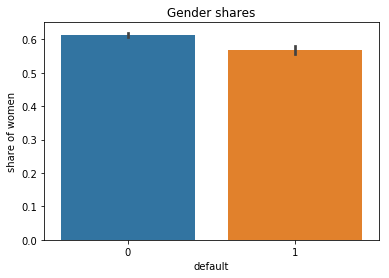

In [24]:
ax = sns.barplot(x="default", y="SEX", data=df)
plt.title('Gender shares')
plt.ylabel('share of women')
plt.show()

Для начала построим интервальную оценку для разности долей независимых выборок

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [25]:
sex_no_default = df.loc[df['default'] == 0, ['SEX']]
sex_default = df.loc[df['default'] == 1, ['SEX']]

In [26]:
men_no_default = (sex_no_default.values == 1).astype('int16')
men_default = (sex_default.values == 1).astype('int16')

In [27]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [28]:
proportions_confint_diff_ind(men_default, men_no_default, 0.05)

(-0.060548077974896725, -0.033634932749628671)

Как видим, доверительный интервал не содердит нуля, следовательно можем заявить, что среди невозвращенных кредитов доля женщин больше, чем среди возвращенных

Протестируем гипотезу о равенстве долей с помощью Z-критерия для разности долей в независимых выборках
- Н0: доля женщин в группе людей не вернувших кредит равна доле мужчин в группе, где вернули кредит
- H1: доли женщин различны в двух выборках

<b>Насколько я понял, для этого критерия не надо проверять никаких условий и можно просто применять его в лоб. Если это не так, напишите в комментарии, и скажите, в каких случаях он не применяется

In [29]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [30]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [31]:
proportions_diff_z_test(proportions_diff_z_stat_ind(men_default, men_no_default))

4.4728665216098307e-12

Исходя из критерия видим, что достигаемый уровень значимости 4.473e-12   
Нулевая гипотеза отвергается на уровне значимости 0.05

## 3

Посмотрим на распределение доли невозвращенных кредитов в зависимости от уровня образования

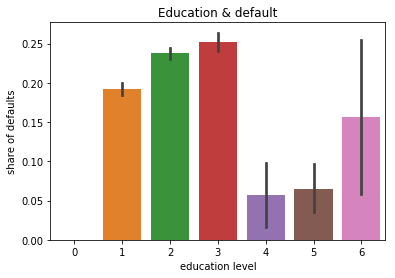

In [10]:
ax = sns.barplot(x="EDUCATION", y="default", data=df)
plt.title('Education & default')
plt.xlabel('education level')
plt.ylabel('share of defaults')
plt.show()

Как видим, люди с уровнем образования "доктор" всегда возвращают долги   
В то же время, люди с уровнем образования "выпускник школы" чаще всего невозвращают кредиты

Представим данные в виде сводной таблицы: образование - статус дефолта

In [65]:
education = df[['default', 'EDUCATION']].copy()
education['count'] = 1
education_pivot = pd.pivot_table(education, values = 'count', index = ['default'], 
                                 columns = ['EDUCATION'], aggfunc = 'count', fill_value = 0)
education_pivot

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


Посмотрим на таблицу разницы ожидаемых и реальных значений

In [49]:
n_j = education_pivot.sum(axis = 1).values.reshape(-1,1)
n_i = education_pivot.sum(axis = 0).values.reshape(1,-1)
predicted_df = pd.DataFrame((np.dot(n_j, n_i) / np.sum(education_pivot.values)).astype(int), 
                            columns = ['education: ' + str(x) for x in range(7)], 
                            index = ['default: ' + str(x) for x in range(2)])
difference_df = pd.DataFrame(predicted_df.values - education_pivot.values, 
                            columns = ['education: ' + str(x) for x in range(7)], 
                            index = ['default: ' + str(x) for x in range(2)])
difference_df

,education: 0,education: 1,education: 2,education: 3,education: 4,education: 5,education: 6
default: 0,-4,-306,226,149,-21,-44,-4
default: 1,3,305,-227,-150,20,43,3


Для лучшей интерпретируемости таблицу разницы в виде отношения разницы к предсказанному значению

In [51]:
difference_perc_df = pd.DataFrame((predicted_df.values - education_pivot.values) / predicted_df.values, 
                            columns = ['education: ' + str(x) for x in range(7)], 
                            index = ['default: ' + str(x) for x in range(2)])
difference_perc_df

,education: 0,education: 1,education: 2,education: 3,education: 4,education: 5,education: 6
default: 0,-0.4,-0.037122,0.020685,0.038914,-0.221053,-0.201835,-0.102564
default: 1,1.0,0.130286,-0.073155,-0.137994,0.740741,0.704918,0.272727


Протестируем гипотезу о независимости образования и статуса дефолта с помощью  критерия хи-квадрат для категориальных признаков
- H0: доля возвращенных кредитов одинакова для всех уровней образования
- H1: доля возвращенных кредитов различна дл разных уровней образования

Для того, чтобы применить данный критерий, необходимо, чтобы количество ячеек в которых ожидаемое значение < 5 было не больше 20%, а так же объем выборки был > 40

Посмотрим на матрицу предскзанных значений

In [63]:
predicted_df

,education: 0,education: 1,education: 2,education: 3,education: 4,education: 5,education: 6
default: 0,10,8243,10926,3829,95,218,39
default: 1,3,2341,3103,1087,27,61,11


In [62]:
np.sum(predicted_df.values < 5) / predicted_df.size

0.071428571428571425

Как видим, всего в 7% значение меньше 5, поэтому можем применить критерий

In [64]:
print('P_value = ', stats.chi2_contingency(education_pivot.values)[1])

P_value =  1.23326262454e-32


Исходя из критерия видим, что достигаемый уровень значимости 1.2334e-32    
Нулевая гипотеза отвергается на уровне значимости 0.05

## 4

Проверим, как связан семейный статус с индикатором дефолта

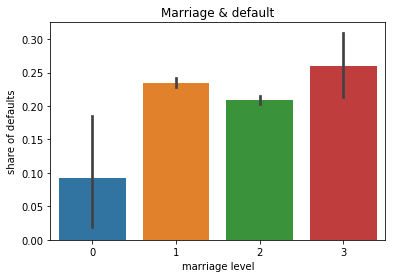

In [68]:
ax = sns.barplot(x="MARRIAGE", y="default", data=df)
plt.title('Marriage & default')
plt.xlabel('marriage level')
plt.ylabel('share of defaults')
plt.show()

In [69]:
marriage = df[['SEX', 'MARRIAGE']].copy()
marriage['count'] = 1

In [70]:
marriage_pivot = pd.pivot_table(marriage, values = 'count', index = ['SEX'], columns = ['MARRIAGE'], aggfunc = 'count')
marriage_pivot

MARRIAGE,0,1,2,3
SEX,,,,
1,14,5190,6553,131
2,40,8469,9411,192


Посмотрим на таблицу ожидаемых значений

In [75]:
n_j = marriage_pivot.sum(axis = 1).values.reshape(-1,1)
n_i = marriage_pivot.sum(axis = 0).values.reshape(1,-1)
predicted_df = pd.DataFrame((np.dot(n_j, n_i) / np.sum(marriage_pivot.values)).astype(int), 
                            columns = ['marriage: ' + str(x) for x in range(4)], 
                            index = ['default: ' + str(x) for x in range(2)])
predicted_df

,marriage: 0,marriage: 1,marriage: 2,marriage: 3
default: 0,21,5412,6326,127
default: 1,32,8246,9637,195


Как видим, ни одно значение не является < 5, а так же объем выборки > 40, поэтому можем вычеслить коэффициент Крамера

In [20]:
print('V Крамера = ', (stats.chi2_contingency(marriage_pivot.values)[0] / (np.sum(marriage_pivot.values))) ** (1/2))

V Крамера =  0.0331713143174


Коэффициент корреляции V Крамера равен 0.033, что показывает довольно слабую взаимосвязь между семейным статусом и индикатором дефолта

## 5

Проверим гипотезу о равенстве медианных значений возрастов людей в групах, где клиенты банка вернули кредит (default = 0) и не вернули кредит (default = 1). 
Проверку будем осуществлять с помощью критерия перестановок
- Н0: медианное значение возраста одинаково в двух группах
- Н1: медианное значение возраста различается в двух группах

In [5]:
age_no_default = df.loc[df['default'] == 0, ['AGE']]
age_default = df.loc[df['default'] == 1, ['AGE']]

Для начала посмотрим на распределение признака возраст в двух группах

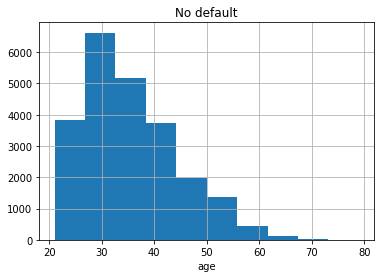

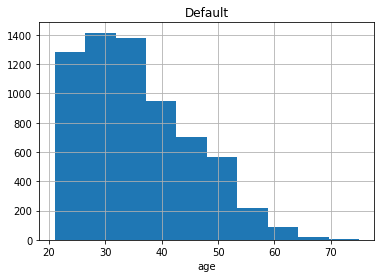

In [19]:
plt.figure(figsize = (10,8))
age_no_default.hist()
plt.xlabel('age')
plt.title('No default')
age_default.hist()
plt.title('Default')
plt.xlabel('age')
plt.show()

In [7]:
def permutation_t_stat_ind(sample1, sample2):
    return np.median(sample1) - np.median(sample2)

In [8]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [11]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = 10000):
    joined_sample = np.vstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    indices = get_random_combinations(n1, len(sample2), max_combinations)
        
    distr = [np.median(joined_sample[list(i[0])]) - np.median(joined_sample[list(i[1])]) \
             for i in indices]
    return distr

In [12]:
def permutation_test_two_sided(sample1, sample2, max_permutations = 10000):
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)

In [13]:
np.random.seed(0)
permutation_test_two_sided(age_no_default, age_default, 1000)

1.0

Исходя из критерия видим, что достигаемый уровень значимости 1.0   
Нам не хватает оснований для того, чтобы отвергнуть нулевую гипотезу

В принципе такой результат легко интерпретировать - интуитивно, возрастные распределения людей в двух группах не должны существенно отличаться

Проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни
- Н0: выборки имеют одно и то же распределение
- Н1: выборки имеют различные распределения

In [20]:
stats.mannwhitneyu(age_no_default, age_default)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.18625177174493079)

Исходя из критерия видим, что достигаемый уровень значимости 0.18625    
Нам не хватает оснований для того, чтобы отвергнуть нулевую гипотеу